In [10]:
import numpy as np
import argparse
import glob
import os
from functools import partial
import vispy
import scipy.misc as misc
from tqdm import tqdm
import yaml
import time
import sys
from mesh import write_ply, read_ply, output_3d_photo
from utils import get_MiDaS_samples, read_MiDaS_depth
import torch
import cv2
from skimage.transform import resize
import imageio
import copy
from networks import Inpaint_Color_Net, Inpaint_Depth_Net, Inpaint_Edge_Net
from MiDaS.run import run_depth
from boostmonodepth_utils import run_boostmonodepth
from MiDaS.monodepth_net import MonoDepthNet
import MiDaS.MiDaS_utils as MiDaS_utils
from bilateral_filtering import sparse_bilateral_filtering

In [11]:
config_dir = 'argument_euroc.yml'

In [12]:
config = yaml.full_load(open(config_dir, 'r'))
if config['offscreen_rendering'] is True:
    vispy.use(app='egl')
os.makedirs(config['mesh_folder'], exist_ok=True)
os.makedirs(config['video_folder'], exist_ok=True)
os.makedirs(config['depth_folder'], exist_ok=True)
sample_list = get_MiDaS_samples(config['src_folder'], config['depth_folder'], config, config['specific'])
normal_canvas, all_canvas = None, None
sample_list

[{'depth_fi': 'depth/IGEV/1403636579763555584_left.npy',
  'ref_img_fi': 'image/EuRoC/1403636579763555584_left.png',
  'int_mtx': array([[1.       , 0.       , 0.5      ],
         [0.       , 1.5666667, 0.5      ],
         [0.       , 0.       , 1.       ]], dtype=float32),
  'ref_pose': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'tgt_pose': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'tgts_poses': [[array([[1.  , 0.  , 0.  , 0.  ],
           [0.  , 1.  , 0.  , 0.  ],
           [0.  , 0.  , 1.  , 0.05],
           [0.  , 0.  , 0.  , 1.  ]]),
    array([[1.        , 0.        , 0.        , 0.        ],
           [0.        , 1.        , 0.        , 0.        ],
           [0.        , 0.        , 1.        , 0.04958159],
           [0.        , 0.        , 0.        , 1.        ]]),
    array([[1.        , 0.        , 0.        , 0.        ],
        

In [13]:
if isinstance(config["gpu_ids"], int) and (config["gpu_ids"] >= 0):
    device = config["gpu_ids"]
else:
    device = "cpu"

print(f"running on device {device}")

running on device 0


In [14]:
idx = 0
depth = None
sample = sample_list[idx]
print("Current Source ==> ", sample['src_pair_name'])
mesh_fi = os.path.join(config['mesh_folder'], sample['src_pair_name'] +'.ply')
image = imageio.imread(sample['ref_img_fi'])

print(f"Running depth extraction at {time.time()}")
if config['use_boostmonodepth'] is True:
    run_boostmonodepth(sample['ref_img_fi'], config['src_folder'], config['depth_folder'])
elif config['require_midas'] is True:
    run_depth([sample['ref_img_fi']], config['src_folder'], config['depth_folder'],
                config['MiDaS_model_ckpt'], MonoDepthNet, MiDaS_utils, target_w=640)

if 'npy' in config['depth_format']:
    config['output_h'], config['output_w'] = np.load(sample['depth_fi']).shape[:2]
else:
    config['output_h'], config['output_w'] = imageio.imread(sample['depth_fi']).shape[:2]

Current Source ==>  1403636579763555584_left
Running depth extraction at 1708877742.3310783


In [15]:
print(config['use_boostmonodepth'], config['require_midas'], 'npy' in config['depth_format'])

False False True


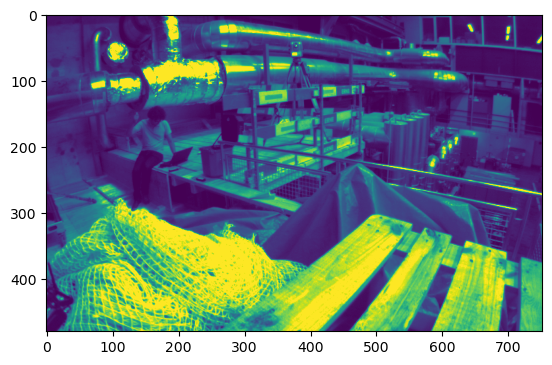

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image)

In [17]:
import yaml
# 读取深度图和视差图的乘积
# Specify the path to the YAML file
file_path_left = 'data/EuRoC/mav0/cam0/sensor.yaml'
file_path_right = 'data/EuRoC/mav0/cam1/sensor.yaml'

# Read the YAML file
with open(file_path_left, 'r') as file:
    data_left = yaml.safe_load(file)
with open(file_path_right, 'r') as file:
    data_right = yaml.safe_load(file)

# Access the data from the YAML file
# For example, if the YAML file contains a key 'key_name', you can access its value like this:
t_left = data_left['T_BS']['data'][3::4][:3]
t_right = data_right['T_BS']['data'][3::4][:3]

# 读取相机内参
fx_left, fx_right = data_left['intrinsics'][0], data_right['intrinsics'][0]

scale_factor = fx_left * np.linalg.norm(np.array(t_left) - np.array(t_right))


In [18]:
def transform_disp_to_depth(disp_fi, disp_rescale=10., h=None, w=None):
    if 'npy' in os.path.splitext(disp_fi)[-1]:
        disp = np.load(disp_fi)
    else:
        disp = imageio.imread(disp_fi).astype(np.float32)

    disp = cv2.blur(disp, ksize=(3, 3))
    if h is not None and w is not None:
        disp = resize(disp, (h, w), order=1)
    depth = scale_factor / (disp + 1e-6)

    return depth

In [19]:
frac = config['longer_side_len'] / max(config['output_h'], config['output_w'])
config['output_h'], config['output_w'] = int(config['output_h'] * frac), int(config['output_w'] * frac)
config['original_h'], config['original_w'] = config['output_h'], config['output_w']
if image.ndim == 2:
    # 处理灰度图像
    image = image[..., None].repeat(3, -1)
if np.sum(np.abs(image[..., 0] - image[..., 1])) == 0 and np.sum(np.abs(image[..., 1] - image[..., 2])) == 0:
    config['gray_image'] = True
else:
    config['gray_image'] = False

image = cv2.resize(image, (config['output_w'], config['output_h']), interpolation=cv2.INTER_AREA)
depth = transform_disp_to_depth(sample['depth_fi'], 3.0, config['output_h'], config['output_w'])
mean_loc_depth = depth[depth.shape[0]//2, depth.shape[1]//2]

print(not(config['load_ply'] is True and os.path.exists(mesh_fi)))

True


In [20]:
if not(config['load_ply'] is True and os.path.exists(mesh_fi)):
    vis_photos, vis_depths = sparse_bilateral_filtering(depth.copy(), image.copy(), config, num_iter=config['sparse_iter'], spdb=False)
    depth = vis_depths[-1]
    model = None
    torch.cuda.empty_cache()
    print("Start Running 3D_Photo ...")
    print(f"Loading edge model at {time.time()}")
    depth_edge_model = Inpaint_Edge_Net(init_weights=True)
    depth_edge_weight = torch.load(config['depth_edge_model_ckpt'],
                                    map_location=torch.device(device))
    depth_edge_model.load_state_dict(depth_edge_weight)
    depth_edge_model = depth_edge_model.to(device)
    depth_edge_model.eval()

    print(f"Loading depth model at {time.time()}")
    depth_feat_model = Inpaint_Depth_Net()
    depth_feat_weight = torch.load(config['depth_feat_model_ckpt'],
                                    map_location=torch.device(device))
    depth_feat_model.load_state_dict(depth_feat_weight, strict=True)
    depth_feat_model = depth_feat_model.to(device)
    depth_feat_model.eval()
    depth_feat_model = depth_feat_model.to(device)
    print(f"Loading rgb model at {time.time()}")
    rgb_model = Inpaint_Color_Net()
    rgb_feat_weight = torch.load(config['rgb_feat_model_ckpt'],
                                    map_location=torch.device(device))
    rgb_model.load_state_dict(rgb_feat_weight)
    rgb_model.eval()
    rgb_model = rgb_model.to(device)
    graph = None


    print(f"Writing depth ply (and basically doing everything) at {time.time()}")
    rt_info = write_ply(image,
                            depth,
                            sample['int_mtx'],
                            mesh_fi,
                            config,
                            rgb_model,
                            depth_edge_model,
                            depth_edge_model,
                            depth_feat_model)

    if rt_info is False:
        print(f'rt_info is False')
    rgb_model = None
    color_feat_model = None
    depth_edge_model = None
    depth_feat_model = None
    torch.cuda.empty_cache()


Start Running 3D_Photo ...
Loading edge model at 1708877759.773383
Loading depth model at 1708877762.048194
Loading rgb model at 1708877763.296244
Writing depth ply (and basically doing everything) at 1708877764.502876
Writing mesh file mesh/IGEV/1403636579763555584_left.ply ...


In [21]:
if config['save_ply'] is True or config['load_ply'] is True:
    verts, colors, faces, Height, Width, hFov, vFov = read_ply(mesh_fi)
else:
    verts, colors, faces, Height, Width, hFov, vFov = rt_info

In [22]:
# 开始渲染
print(f"Making video at {time.time()}")

videos_poses, video_basename = copy.deepcopy(sample['tgts_poses']), sample['tgt_name']
top = (config.get('original_h') // 2 - sample['int_mtx'][1, 2] * config['output_h'])
left = (config.get('original_w') // 2 - sample['int_mtx'][0, 2] * config['output_w'])
down, right = top + config['output_h'], left + config['output_w']
border = [int(xx) for xx in [top, down, left, right]]

Making video at 1708878247.4867032


In [23]:
try:
    import cynetworkx as netx
except ImportError:
    import networkx as netx
from mesh import Canvas_view
import transforms3d
    
def output_novel_view(verts, colors, faces, Height, Width, hFov, vFov, tgt_poses, video_traj_types, ref_pose,
                    output_dir, ref_image, int_mtx, config, image, videos_poses, video_basename, original_H=None, original_W=None,
                    border=None, depth=None, normal_canvas=None, all_canvas=None, mean_loc_depth=None, tgt_pose=None):

    cam_mesh = netx.Graph()
    cam_mesh.graph['H'] = Height
    cam_mesh.graph['W'] = Width
    cam_mesh.graph['original_H'] = original_H
    cam_mesh.graph['original_W'] = original_W
    int_mtx_real_x = int_mtx[0] * Width
    int_mtx_real_y = int_mtx[1] * Height
    cam_mesh.graph['hFov'] = 2 * np.arctan((1. / 2.) * ((cam_mesh.graph['original_W']) / int_mtx_real_x[0]))
    cam_mesh.graph['vFov'] = 2 * np.arctan((1. / 2.) * ((cam_mesh.graph['original_H']) / int_mtx_real_y[1]))
    colors = colors[..., :3]

    fov_in_rad = max(cam_mesh.graph['vFov'], cam_mesh.graph['hFov'])
    fov = (fov_in_rad * 180 / np.pi)
    print("fov: " + str(fov))
    init_factor = 1
    if config.get('anti_flickering') is True:
        init_factor = 3
    if (cam_mesh.graph['original_H'] is not None) and (cam_mesh.graph['original_W'] is not None):
        canvas_w = cam_mesh.graph['original_W']
        canvas_h = cam_mesh.graph['original_H']
    else:
        canvas_w = cam_mesh.graph['W']
        canvas_h = cam_mesh.graph['H']
    canvas_size = max(canvas_h, canvas_w)
    if normal_canvas is None:
        normal_canvas = Canvas_view(fov,
                                    verts,
                                    faces,
                                    colors,
                                    canvas_size=canvas_size,
                                    factor=init_factor,
                                    bgcolor='gray',
                                    proj='perspective')
    else:
        normal_canvas.reinit_mesh(verts, faces, colors)
        normal_canvas.reinit_camera(fov)
    img = normal_canvas.render()
    backup_img, backup_all_img, all_img_wo_bound = img.copy(), img.copy() * 0, img.copy() * 0
    img = cv2.resize(img, (int(img.shape[1] / init_factor), int(img.shape[0] / init_factor)), interpolation=cv2.INTER_AREA)
    if border is None:
        border = [0, img.shape[0], 0, img.shape[1]]
    H, W = cam_mesh.graph['H'], cam_mesh.graph['W']
    if (cam_mesh.graph['original_H'] is not None) and (cam_mesh.graph['original_W'] is not None):
        aspect_ratio = cam_mesh.graph['original_H'] / cam_mesh.graph['original_W']
    else:
        aspect_ratio = cam_mesh.graph['H'] / cam_mesh.graph['W']
    if aspect_ratio > 1:
        img_h_len = cam_mesh.graph['H'] if cam_mesh.graph.get('original_H') is None else cam_mesh.graph['original_H']
        img_w_len = img_h_len / aspect_ratio
        anchor = [0,
                  img.shape[0],
                  int(max(0, int((img.shape[1])//2 - img_w_len//2))),
                  int(min(int((img.shape[1])//2 + img_w_len//2), (img.shape[1])-1))]
    elif aspect_ratio <= 1:
        img_w_len = cam_mesh.graph['W'] if cam_mesh.graph.get('original_W') is None else cam_mesh.graph['original_W']
        img_h_len = img_w_len * aspect_ratio
        anchor = [int(max(0, int((img.shape[0])//2 - img_h_len//2))),
                  int(min(int((img.shape[0])//2 + img_h_len//2), (img.shape[0])-1)),
                  0,
                  img.shape[1]]
    anchor = np.array(anchor)
    plane_width = np.tan(fov_in_rad/2.) * np.abs(mean_loc_depth)

    rel_pose = np.linalg.inv(np.dot(tgt_pose, np.linalg.inv(ref_pose)))
    axis, angle = transforms3d.axangles.mat2axangle(rel_pose[0:3, 0:3])
    normal_canvas.rotate(axis=axis, angle=(angle*180)/np.pi)
    normal_canvas.translate(rel_pose[:3,3])
    new_mean_loc_depth = mean_loc_depth - float(rel_pose[2, 3])
    normal_canvas.reinit_camera(fov)
    normal_canvas.view_changed()
    img = normal_canvas.render()
    img = cv2.GaussianBlur(img,(int(init_factor//2 * 2 + 1), int(init_factor//2 * 2 + 1)), 0)
    img = cv2.resize(img, (int(img.shape[1] / init_factor), int(img.shape[0] / init_factor)), interpolation=cv2.INTER_AREA)
    img = img[anchor[0]:anchor[1], anchor[2]:anchor[3]]
    img = img[int(border[0]):int(border[1]), int(border[2]):int(border[3])]

    if any(np.array(config['crop_border']) > 0.0):
        H_c, W_c, _ = img.shape
        o_t = int(H_c * config['crop_border'][0])
        o_l = int(W_c * config['crop_border'][1])
        o_b = int(H_c * config['crop_border'][2])
        o_r = int(W_c * config['crop_border'][3])
        img = img[o_t:H_c-o_b, o_l:W_c-o_r]
        img = cv2.resize(img, (W_c, H_c), interpolation=cv2.INTER_CUBIC)
    stereo = img[..., :3]
    normal_canvas.translate(-rel_pose[:3,3])
    normal_canvas.rotate(axis=axis, angle=-(angle*180)/np.pi)
    normal_canvas.view_changed()

    # ====================
    atop = 0; abuttom = img.shape[0] - img.shape[0] % 2; aleft = 0; aright = img.shape[1] - img.shape[1] % 2
    stereo = (stereo[atop:abuttom, aleft:aright, :3] * 1).astype(np.uint8)

    return stereo

In [24]:
import pandas as pd

def read_quaternions_from_csv(file_path):
    df = pd.read_csv(file_path)
    quaternions = df[['#timestamp', ' q_RS_w []', ' q_RS_x []', ' q_RS_y []', ' q_RS_z []', ' p_RS_R_x [m]', ' p_RS_R_y [m]', ' p_RS_R_z [m]']]
    return quaternions

def get_quaternion_by_timestamp(quaternions, timestamp):
    quaternion = quaternions[quaternions['#timestamp'] == timestamp]
    return quaternion

def quaternion_to_rotation_matrix(quaternion_df):
    quaternion = quaternion_df[[' q_RS_w []', ' q_RS_x []', ' q_RS_y []', ' q_RS_z []']].values[0]
    w, x, y, z = quaternion
    Nq = w*w + x*x + y*y + z*z
    if Nq < np.finfo(float).eps:
        return np.identity(3)
    s = 2.0/Nq
    X = x*s; Y = y*s; Z = z*s
    wX = w*X; wY = w*Y; wZ = w*Z
    xX = x*X; xY = x*Y; xZ = x*Z
    yY = y*Y; yZ = y*Z; zZ = z*Z
    return np.array(
           [[ 1.0-(yY+zZ), xY-wZ, xZ+wY ],
            [ xY+wZ, 1.0-(xX+zZ), yZ-wX ],
            [ xZ-wY, yZ+wX, 1.0-(xX+yY) ]])

def quaternion_to_position(quaternion_df):
    position = quaternion_df[[' p_RS_R_x [m]', ' p_RS_R_y [m]', ' p_RS_R_z [m]']].values[0]
    return position

def get_pose_matrix(rotation_matrix, x, y, z):
    pose_matrix = np.eye(4)
    pose_matrix[:3, :3] = rotation_matrix
    pose_matrix[:3, 3] = [x, y, z]
    return pose_matrix

# 使用你的csv文件路径替换'your_file_path.csv'
quaternions = read_quaternions_from_csv('data/EuRoC/mav0/state_groundtruth_estimate0/data.csv')
quaternion = get_quaternion_by_timestamp(quaternions, 1403636580838555648)
rotation_matrix = quaternion_to_rotation_matrix(quaternion)
x, y, z = quaternion_to_position(quaternion)
pose_matrix = get_pose_matrix(rotation_matrix, x, y, z)

print(rotation_matrix)
print(pose_matrix)

[[-0.38262204  0.34098299 -0.85867979]
 [ 0.16547097  0.9396664   0.29941012]
 [ 0.9089663  -0.02752567 -0.41595986]]
[[-0.38262204  0.34098299 -0.85867979  4.688319  ]
 [ 0.16547097  0.9396664   0.29941012 -1.786938  ]
 [ 0.9089663  -0.02752567 -0.41595986  0.783338  ]
 [ 0.          0.          0.          1.        ]]


In [25]:
def timestamp_to_pose_matrix(quaternions, timestamp):
    quaternion = get_quaternion_by_timestamp(quaternions, timestamp)
    rotation_matrix = quaternion_to_rotation_matrix(quaternion)
    x, y, z = quaternion_to_position(quaternion)
    pose_matrix = get_pose_matrix(rotation_matrix, x, y, z)
    return pose_matrix

fov: 53.13010235415598


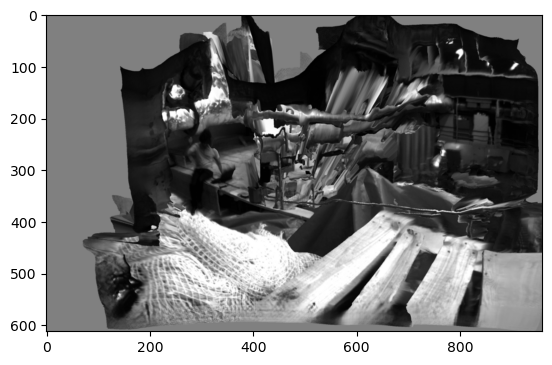

In [26]:
quaternions = read_quaternions_from_csv('data/EuRoC/mav0/state_groundtruth_estimate0/data.csv')
ref_pose = timestamp_to_pose_matrix(quaternions, 1403636580838555648)
tgt_pose = timestamp_to_pose_matrix(quaternions, 1403636581083555584)

noval_view = output_novel_view(verts.copy(), colors.copy(), faces.copy(), copy.deepcopy(Height), copy.deepcopy(Width), copy.deepcopy(hFov), copy.deepcopy(vFov),
                        copy.deepcopy(sample['tgt_pose']), sample['video_postfix'], ref_pose, copy.deepcopy(config['video_folder']),
                        image.copy(), copy.deepcopy(sample['int_mtx']), config, image,
                        videos_poses, video_basename, config.get('original_h'), config.get('original_w'), border=border, depth=depth, normal_canvas=normal_canvas, all_canvas=all_canvas,
                        mean_loc_depth=mean_loc_depth, tgt_pose=tgt_pose)

plt.figure()
plt.imshow(noval_view)

In [27]:
len(quaternions)

36382

In [28]:
len(glob.glob('/data3/dn/project/IGEV/IGEV-Stereo/data/EuRoC/mav0/cam0/data/*.png'))

3682

In [29]:
ref_pose

array([[-0.38262204,  0.34098299, -0.85867979,  4.688319  ],
       [ 0.16547097,  0.9396664 ,  0.29941012, -1.786938  ],
       [ 0.9089663 , -0.02752567, -0.41595986,  0.783338  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [30]:
tgt_pose

array([[-0.32646544,  0.35238454, -0.87706639,  4.682501  ],
       [ 0.1278915 ,  0.93584216,  0.32839492, -1.784651  ],
       [ 0.93651699, -0.00495974, -0.35058711,  0.969077  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])